<a href="https://colab.research.google.com/github/howie-cn/stylegan2tf2x/blob/master/sgantf2_training_with_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 准备环境

In [4]:
from google.colab import auth
auth.authenticate_user()

In [2]:
# 进行google 授权，以便于读取gcs, google drive
# from google.colab import auth
# auth.authenticate_user()
# %cd /content/drive/My\ Drive/stylegan/sgan2tf2x


## 导入标准包
import os
import datetime
import numpy as np
import tensorflow as tf
from train_basic import *

[Errno 2] No such file or directory: '/content/drive/My Drive/stylegan/sgan2tf2x'
/content


ModuleNotFoundError: ignored

# 准备参数

In [ ]:
# 准备参数

n_samples=200
batch_size=1
train_res=1024

epochs=1

model_base_dir='gs://howiecao_gcs/tfgan_model'
tfrecord_dir='gs://howiecao_gcs/yellowlite'



# 网络参数
resolutions = [  4,   8,  16,  32,  64, 128, 256, 512, 1024]
featuremaps = [512, 512, 512, 512, 512, 256, 128,  64,   32]
train_resolutions, train_featuremaps = filter_resolutions_featuremaps(resolutions, featuremaps, train_res)
# 生成网络参数
g_params = {
    'z_dim': 512,
    'w_dim': 512,
    'labels_dim': 0,
    'n_mapping': 8,
    'resolutions': train_resolutions,
    'featuremaps': train_featuremaps,
    'w_ema_decay': 0.995,
    'style_mixing_prob': 0.9,
}
# 判别网络参数
d_params = {
    'labels_dim': 0,
    'resolutions': train_resolutions,
    'featuremaps': train_featuremaps,
}

# training parameters
training_parameters = {
    #dataset parameter
    'model_base_dir': 'gs://howiecao_gcs/tfgan_model',
    'tfrecord_dir': 'gs://howiecao_gcs/yellowlite',
    'shuffle_buffer_size':n_samples,

    # network params
    'g_params': g_params,
    'd_params': d_params,

    # training params
    'g_opt': {'learning_rate': 0.002, 'beta1': 0.0, 'beta2': 0.99, 'epsilon': 1e-08, 'reg_interval': 4},
    'd_opt': {'learning_rate': 0.002, 'beta1': 0.0, 'beta2': 0.99, 'epsilon': 1e-08, 'reg_interval': 16},
    'batch_size': batch_size,
    'n_total_image': 200,
    'n_samples': n_samples,
    'lazy_regularization': True,
}


In [ ]:
trainer = Trainer(training_parameters, name='stylegan2-ffhq')
trainer.train()

Setting datasets
Create models


InvalidArgumentError: ignored

# 准备数据集

In [ ]:
train_dataset = get_gcs_dataset(training_parameters['tfrecord_dir'], 
                            train_res, 
                            training_parameters['shuffle_buffer_size'],
                            batch_size, 
                            epochs=epochs
                            )
#train_dataset=train_dataset.prefetch

In [ ]:

model_base_dir = t_params['model_base_dir']
tfrecord_dir = t_params['tfrecord_dir']
shuffle_buffer_size = t_params['shuffle_buffer_size']

g_opt = t_params['g_opt']
d_opt = t_params['d_opt']
batch_size = t_params['batch_size']
n_total_image = t_params['n_total_image']
n_samples = min(t_params['batch_size'], t_params['n_samples'])
lazy_regularization = t_params['lazy_regularization']

r1_gamma = 10.0
# self.r2_gamma = 0.0
max_steps = int(np.ceil(self.n_total_image / self.batch_size))
out_res = self.g_params['resolutions'][-1]
log_template = 'step {}: elapsed: {:.2f}s, d_loss: {:.3f}, g_loss: {:.3f}, r1_reg: {:.3f}, pl_reg: {:.3f}'
print_step = 10
save_step = 100
image_summary_step = 100

reached_max_steps = False

# 设置优化器参数
self.g_opt = self.set_optimizer_params(self.g_opt)
self.d_opt = self.set_optimizer_params(self.d_opt)

self.pl_mean = tf.Variable(initial_value=0.0, name='pl_mean', trainable=False)

self.pl_decay = 0.01

self.pl_weight = 1.0

self.pl_denorm = 1.0 / np.sqrt(self.out_res * self.out_res)

In [ ]:
# allow_memory_growth()
class Trainer(object):
    def __init__(self, t_params, name):
        self.model_base_dir = t_params['model_base_dir']
        self.tfrecord_dir = t_params['tfrecord_dir']
        self.shuffle_buffer_size = t_params['shuffle_buffer_size']
        self.g_params = t_params['g_params']
        self.d_params = t_params['d_params']
        self.g_opt = t_params['g_opt']
        self.d_opt = t_params['d_opt']
        self.batch_size = t_params['batch_size']
        self.n_total_image = t_params['n_total_image']
        self.n_samples = min(t_params['batch_size'], t_params['n_samples'])
        self.lazy_regularization = t_params['lazy_regularization']

        self.r1_gamma = 10.0
        # self.r2_gamma = 0.0
        self.max_steps = int(np.ceil(self.n_total_image / self.batch_size))
        self.out_res = self.g_params['resolutions'][-1]
        self.log_template = 'step {}: elapsed: {:.2f}s, d_loss: {:.3f}, g_loss: {:.3f}, r1_reg: {:.3f}, pl_reg: {:.3f}'
        self.print_step = 10
        self.save_step = 100
        self.image_summary_step = 100

        self.reached_max_steps = False

        # 设置优化器参数
        self.g_opt = self.set_optimizer_params(self.g_opt)
        self.d_opt = self.set_optimizer_params(self.d_opt)

        self.pl_mean = tf.Variable(initial_value=0.0, name='pl_mean', trainable=False)

        self.pl_decay = 0.01
        
        self.pl_weight = 1.0
        
        self.pl_denorm = 1.0 / np.sqrt(self.out_res * self.out_res)

        self.dataset= get_gcs_dataset(training_parameters['tfrecord_dir'], 
                            self.out_res, 
                            self.shuffle_buffer_size,
                            self.batch_size, 
                            epochs=None
                            )



        # create models
        print('构建模型')
        print('生成器')
        self.generator = Generator(self.g_params)
        print('判别器')
        self.discriminator = Discriminator(self.d_params)
        
        self.d_optimizer = tf.keras.optimizers.Adam(self.d_opt['learning_rate'],
                                                    beta_1=self.d_opt['beta1'],
                                                    beta_2=self.d_opt['beta2'],
                                                    epsilon=self.d_opt['epsilon'])
        self.g_optimizer = tf.keras.optimizers.Adam(self.g_opt['learning_rate'],
                                                    beta_1=self.g_opt['beta1'],
                                                    beta_2=self.g_opt['beta2'],
                                                    epsilon=self.g_opt['epsilon'])
        print('全局平均判别器')
        self.g_clone = Generator(self.g_params)

        # finalize model (build)
        latents_in = np.ones((1, self.g_params['z_dim']), dtype=np.float32)
        labels_in = np.ones((1, self.g_params['labels_dim']), dtype=np.float32)
        images_in = np.ones((1, 3, self.out_res, self.out_res), dtype=np.float32)

        _, __ = self.generator([latents_in, labels_in], training=False)
        _ = self.discriminator([images_in, labels_in], training=False)
        _, __ = self.g_clone([latents_in, labels_in], training=False)

        print('Copying g_clone for average weighting')
        self.g_clone.set_weights(self.generator.get_weights())

        # setup saving locations (object based savings)
        self.ckpt_dir = os.path.join(self.model_base_dir, name)

        self.ckpt = tf.train.Checkpoint(
            d_optimizer=self.d_optimizer,
            g_optimizer=self.g_optimizer,
            discriminator=self.discriminator,
            generator=self.generator,
            g_clone=self.g_clone
            )
        self.manager = tf.train.CheckpointManager(self.ckpt, self.ckpt_dir, max_to_keep=2)

        # 如果有存储的检查点，则试图先恢复已保存的检查点
        self.ckpt.restore(self.manager.latest_checkpoint)
        if self.manager.latest_checkpoint:
            print('Restored from {}'.format(self.manager.latest_checkpoint))

            # check if already trained in this resolution
            restored_step = self.g_optimizer.iterations.numpy()
            if restored_step >= self.max_steps:
                print('Already reached max steps {}/{}'.format(restored_step, self.max_steps))
                self.reached_max_steps = True
                return
        else:
            print('Not restoring from saved checkpoint')



    @tf.function
    def d_train_step(self, z, real_images, labels):
        with tf.GradientTape() as d_tape:
            # forward pass 前馈传递
            # 生成器生成一张假的图片
            fake_images, _ = self.generator([z, labels], training=True)
            # 判别器判断为真的概率
            real_scores = self.discriminator([real_images, labels], training=True)
            # 判别器判断为假的概率
            fake_scores = self.discriminator([fake_images, labels], training=True)

            # gan loss gan损失
            # 
            d_loss = tf.math.softplus(fake_scores)
            d_loss = d_loss+tf.math.softplus(-real_scores)
            d_loss = tf.reduce_mean(d_loss)
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        return d_loss

    @tf.function
    def d_reg_train_step(self, z, real_images, labels):
        with tf.GradientTape() as d_tape:
            # forward pass
            fake_images, _ = self.generator([z, labels], training=True)
            real_scores = self.discriminator([real_images, labels], training=True)
            fake_scores = self.discriminator([fake_images, labels], training=True)

            # gan loss
            d_loss = tf.math.softplus(fake_scores)
            d_loss = d_loss+tf.math.softplus(-real_scores)

            # simple GP
            with tf.GradientTape() as p_tape:
                p_tape.watch(real_images)
                real_loss = tf.reduce_sum(self.discriminator([real_images, labels], training=True))

            real_grads = p_tape.gradient(real_loss, real_images)
            r1_penalty = tf.reduce_sum(tf.math.square(real_grads), axis=[1, 2, 3])
            r1_penalty = tf.expand_dims(r1_penalty, axis=1)
            r1_penalty = r1_penalty * self.d_opt['reg_interval']

            # combine
            d_loss = d_loss+ r1_penalty * (0.5 * self.r1_gamma)
            d_loss = tf.reduce_mean(d_loss)

        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        return d_loss, tf.reduce_mean(r1_penalty)

    @tf.function
    def g_train_step(self, z, labels):
        with tf.GradientTape() as g_tape:
            # forward pass
            fake_images, _ = self.generator([z, labels], training=True)
            fake_scores = self.discriminator([fake_images, labels], training=True)

            # gan loss
            g_loss = tf.math.softplus(-fake_scores)
            g_loss = tf.reduce_mean(g_loss)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        return g_loss

    @tf.function
    def g_reg_train_step(self, z, labels):
        with tf.GradientTape() as g_tape:
            # forward pass
            fake_images, _ = self.generator([z, labels], training=True)
            fake_scores = self.discriminator([fake_images, labels], training=True)

            # gan loss
            g_loss = tf.math.softplus(-fake_scores)

            # path length regularization
            # Compute |J*y|.
            with tf.GradientTape() as pl_tape:
                fake_images, w_broadcasted = self.generator([z, labels], training=True)

                pl_noise = tf.random.normal(tf.shape(fake_images), mean=0.0, stddev=1.0, dtype=tf.float32) * self.pl_denorm
                pl_noise_added = tf.reduce_sum(fake_images * pl_noise)

            pl_grads = pl_tape.gradient(pl_noise_added, w_broadcasted)
            pl_lengths = tf.math.sqrt(tf.reduce_mean(tf.reduce_sum(tf.math.square(pl_grads), axis=2), axis=1))

            # Track exponential moving average of |J*y|.
            pl_mean_val = self.pl_mean + self.pl_decay * (tf.reduce_mean(pl_lengths) - self.pl_mean)
            self.pl_mean.assign(pl_mean_val)

            # Calculate (|J*y|-a)^2.
            pl_penalty = tf.square(pl_lengths - self.pl_mean)

            # compute
            pl_reg = pl_penalty * self.pl_weight

            # combine
            g_loss = g_loss+pl_reg
            g_loss = tf.reduce_mean(g_loss)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        return g_loss, tf.reduce_mean(pl_reg)

    def train(self):

        if self.reached_max_steps:
            return
        
        print('开始训练{}'.format(datetime.datetime.now()))

        # setup tensorboards
        train_summary_writer = tf.summary.create_file_writer(self.ckpt_dir)

        # loss metrics
        metric_g_loss = tf.keras.metrics.Mean('g_loss', dtype=tf.float32)
        metric_d_loss = tf.keras.metrics.Mean('d_loss', dtype=tf.float32)
        metric_r1_reg = tf.keras.metrics.Mean('r1_reg', dtype=tf.float32)
        metric_pl_reg = tf.keras.metrics.Mean('pl_reg', dtype=tf.float32)

        # start training
        print('max_steps: {}'.format(self.max_steps))
        losses = {
            'g_loss': 0.0,
            'd_loss': 0.0, 
            'r1_reg': 0.0, 
            'pl_reg': 0.0
            }

        t_start = time.time()

        print('before training loop')
        for real_images in self.dataset:
            # preprocess inputs

            z = tf.random.normal(shape=[tf.shape(real_images)[0], self.g_params['z_dim']], dtype=tf.dtypes.float32)

            print('debug 00')
            real_images = preprocess_fit_train_image(real_images, self.out_res)


            print('image shape is {}'.format(real_images.shape))

            labels = tf.ones((tf.shape(real_images)[0], self.g_params['labels_dim']), dtype=tf.dtypes.float32)

            # get current step
            step = self.g_optimizer.iterations.numpy()

            # d train step
            if step % self.d_opt['reg_interval'] == 0:
                d_loss, r1_reg = self.d_reg_train_step(z, real_images, labels)

                # update values for printing
                losses['d_loss'] = d_loss.numpy()
                losses['r1_reg'] = r1_reg.numpy()

                # update metrics
                metric_d_loss(d_loss)
                metric_r1_reg(r1_reg)
            else:
                d_loss = self.d_train_step(z, real_images, labels)

                # update values for printing
                losses['d_loss'] = d_loss.numpy()
                losses['r1_reg'] = 0.0

                # update metrics
                metric_d_loss(d_loss)

            # update g_clone
            # 全局移动平均权重
            self.g_clone.set_as_moving_average_of(self.generator)

            # g train step
            if step % self.g_opt['reg_interval'] == 0:
                g_loss, pl_reg = self.g_reg_train_step(z, labels)

                # update values for printing
                losses['g_loss'] = g_loss.numpy()
                losses['pl_reg'] = pl_reg.numpy()

                # update metrics
                metric_g_loss(g_loss)
                metric_pl_reg(pl_reg)
            else:
                g_loss = self.g_train_step(z, labels)

                # update values for printing
                losses['g_loss'] = g_loss.numpy()
                losses['pl_reg'] = 0.0

                # update metrics
                metric_g_loss(g_loss)

            # save to tensorboard
            with train_summary_writer.as_default():
                tf.summary.scalar('g_loss', metric_g_loss.result(), step=step)
                tf.summary.scalar('d_loss', metric_d_loss.result(), step=step)
                tf.summary.scalar('r1_reg', metric_r1_reg.result(), step=step)
                tf.summary.scalar('pl_reg', metric_pl_reg.result(), step=step)
                tf.summary.histogram('w_avg', self.generator.w_avg, step=step)

            # save every self.save_step
            if step % self.save_step == 0:
                self.manager.save(checkpoint_number=step)

            # save every self.image_summary_step
            if step % self.image_summary_step == 0:
                # add summary image
                summary_image = self.sample_images_tensorboard(real_images)
                with train_summary_writer.as_default():
                    tf.summary.image('images', summary_image, step=step)

            # print every self.print_steps
            if step % self.print_step == 0:
                elapsed = time.time() - t_start
                print(self.log_template.format(step, elapsed,
                                               losses['d_loss'], losses['g_loss'], losses['r1_reg'], losses['pl_reg']))

                # reset timer
                t_start = time.time()

            # check exit status
            if step >= self.max_steps:
                break

        #  获取当前step
        step = self.g_optimizer.iterations.numpy()
        elapsed = time.time() - t_start
        print(self.log_template.format(step, elapsed,losses['d_loss'], losses['g_loss'], losses['r1_reg'], losses['pl_reg']))

        # save last checkpoint 
        self.manager.save(checkpoint_number=step)
        return

    def sample_images_tensorboard(self, real_images):
        # prepare inputs
        reals = real_images[:self.n_samples, :, :, :]
        latents = tf.random.normal(shape=(self.n_samples, self.g_params['z_dim']), dtype=tf.dtypes.float32)
        dummy_labels = tf.ones((self.n_samples, self.g_params['labels_dim']), dtype=tf.dtypes.float32)

        # run networks
        fake_images_00, _ = self.g_clone([latents, dummy_labels], truncation_psi=0.0, training=False)
        fake_images_05, _ = self.g_clone([latents, dummy_labels], truncation_psi=0.5, training=False)
        fake_images_07, _ = self.g_clone([latents, dummy_labels], truncation_psi=0.7, training=False)
        fake_images_10, _ = self.g_clone([latents, dummy_labels], truncation_psi=1.0, training=False)

        # merge on batch dimension: [5 * n_samples, 3, out_res, out_res]
        out = tf.concat([reals, fake_images_00, fake_images_05, fake_images_07, fake_images_10], axis=0)

        # prepare for image saving: [5 * n_samples, out_res, out_res, 3]
        out = postprocess_images(out)

        # resize to save disk spaces: [5 * n_samples, size, size, 3]
        size = min(self.out_res, 256)
        out = tf.image.resize(out, size=[size, size])

        # make single image and add batch dimension for tensorboard: [1, 5 * size, n_samples * size, 3]
        out = merge_batch_images(out, size, rows=5, cols=self.n_samples)
        out = np.expand_dims(out, axis=0)
        return out






# 构建模型
trainer = Trainer(training_parameters, 
            name='stylegan2-yellow'
                  )

trainer.train()


构建模型
生成器
判别器
全局平均判别器


InvalidArgumentError: ignored

## 训练

In [ ]:

# 构建模型
trainer = Trainer(training_parameters, 
            name='stylegan2-yellow'
                  )

trainer.train()


# 附录

## 制作TFRecords

In [ ]:
%cd /content/drive/My Drive/datasets/faceset/yellow/

/content/drive/My Drive/datasets/faceset/yellow


In [ ]:
import os 
import tensorflow as tf 
from PIL import Image  
import matplotlib.pyplot as plt 
import numpy as np
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [ ]:
data_root=pathlib.Path('/content/drive/My Drive/datasets/faceset/yellow/') 
#tfrecord_file="/content/drive/My Drive/datasets/yellowlite.tfrecords"
tfrecord_file="gs://howiecao_gcs/yellowlite/yellowlite.tfrecords"


all_image_paths = list(data_root.glob('*.png'))
all_image_paths = [str(path) for path in all_image_paths]

writer= tf.io.TFRecordWriter(tfrecord_file) #要生成的文件


for img_path in all_image_paths: 

    image= plt.imread(img_path)
    image_shape = image.shape
    
    image_bytes = image.tobytes()

    example=tf.train.Example(
        features=tf.train.Features(
           feature = {
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=image_shape)),
                'data':  tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes])) 
                }
                )
        )

    example_str = example.SerializeToString()
    writer.write(example_str)

writer.close()

In [ ]:
feature = {
    'shape':  tf.io.FixedLenFeature([3], tf.int64),
    'data':  tf.io.FixedLenFeature([], tf.string) 
        }

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature)

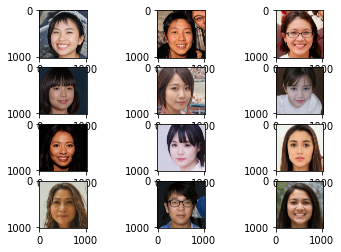

In [ ]:
raw_dataset = tf.data.TFRecordDataset([tfrecord_file])
parsed_image_dataset = raw_dataset.map(_parse_image_function)

i=0
for m  in parsed_image_dataset.take(12):
    i=i+1
    image_shape=m['shape']
    #print(m['data'].)
    im=tf.io.decode_raw(m['data'],out_type=tf.float32)
    im = tf.reshape(im,image_shape)
    plt.subplot(4,3,i)
    plt.imshow(im)


In [ ]:
def parse_tfrecord_tf(record):

    feature = {
            'shape':  tf.io.FixedLenFeature([3], tf.int64),
            'data':  tf.io.FixedLenFeature([], tf.string)
            }

    features = tf.io.parse_single_example(record, feature)

    # [0 ~ 255] uint8
    images = tf.io.decode_raw(features['data'], tf.dtypes.float32)
    images = tf.reshape(images, features['shape'])

    # [0.0 ~ 255.0] float32
    images = tf.cast(images, tf.dtypes.float32)

    images = tf.transpose(images,[2,0,1])
    return images

In [ ]:
%cd /content/drive/My\ Drive/datasets/y3

/content/drive/My Drive/datasets/y3


In [ ]:
!cat race_yellow.* > y3.zip